In [1]:
import os 
import numpy as np 
import pandas as pd 
import networkx as nx
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from IPython.display import display, HTML
from scipy.spatial.distance import squareform

In [2]:
PPI_list = pd.read_csv('../../data/pipeline/PPI_reference_barcodes.csv')
PPI_list['PPI_bait'] =  [ PPI_list['PPI'][idx].split('_')[0] for idx in PPI_list.index ]
PPI_list['PPI_prey'] =  [ PPI_list['PPI'][idx].split('_')[1] for idx in PPI_list.index ]

In [3]:
def get_chr(x, gene_loc):
    try : 
        return gene_loc[gene_loc['Gene'] == x]['Chromosome_Name'].values[0].replace('CHR', '')
    except : 
        return np.nan
        
def set_correlation_score(idx, table):
    z_score = table['-log_pval'][idx]
    if z_score > 4 : #### Here you can play with this threshold
        return 1 
    else :
        return 0

In [4]:
#### Here I'm building the manhatthan similarity matrix across all the conditions
folder_path = '../../data/piQTLs/piQTL_original'
all_MTX = []
MTX_ALL_RESULTS = []
MTX_correlation_matrix = []
for PPI in tqdm(PPI_list['PPI']): 
    for DRUG in ['noDrug', '5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine'] : 
        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        MTX['Condition'] = f'{PPI}_MTX_{DRUG}'
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        all_MTX.append(MTX[MTX.columns[:-1]])
        MTX_correlation_matrix.append(MTX[['SNP_ID', f'{PPI}_MTX_{DRUG}']].set_index(['SNP_ID']).T)

MTX_ALL_RESULTS = pd.concat(all_MTX)
MTX_DF = pd.concat(MTX_correlation_matrix) 

100%|██████████| 62/62 [01:22<00:00,  1.33s/it]


In [5]:
#### You need to remove the MTX-specific piQTLs before performing the other steps
MTX_QTLs = pd.read_csv('../../results/05_piQTL_tables/MTX_specific_QTLs_with_genome_annotations.csv')
MTX_QTLs['SNP_ID'] = [ f'CHR{MTX_QTLs["Chr"][idx]}_{MTX_QTLs["SNP"][idx]}' for idx in MTX_QTLs.index ]
MTX_piQTLs = list(MTX_QTLs['SNP_ID'])
MTX_piQTLs.append('CHR15_10435')
MTX_piQTLs.append('CHR15_10455')
MTX_piQTLs.append('CHR15_10456')
MTX_piQTLs.append('CHR15_10468')

In [6]:
ALL_piQTLs = MTX_ALL_RESULTS[(MTX_ALL_RESULTS['-log_pval'] >= 4) & ~(MTX_ALL_RESULTS['SNP_ID'].isin(MTX_piQTLs)) & ~(MTX_ALL_RESULTS['Condition'].str.contains('noPPI_reference'))].reset_index(drop=True)

In [7]:
# ALL_piQTLs = MTX_ALL_RESULTS[(MTX_ALL_RESULTS['-log_pval'] >= 4.4) & ~(MTX_ALL_RESULTS['SNP_ID'].isin(MTX_piQTLs)) & ~(MTX_ALL_RESULTS['Condition'].str.contains('noPPI_reference'))].reset_index(drop=True)
ALL_piQTLs['DRUG'] = [ ALL_piQTLs['Condition'][idx].split('_')[-1] for idx in ALL_piQTLs.index ]

In [10]:
GENE_COORDINATES = pd.read_csv('../../data/genome_annotations/sgd_database/orf_coding_R64-3-1.csv')
GENE_COORDINATES['chrom'] = [ GENE_COORDINATES['chrom'][idx].replace('_', '').replace('1000', 'MT') for idx in GENE_COORDINATES.index ]

In [78]:
def get_piQTL_distance(idx):
    BAIT = ALL_piQTLs['Condition'][idx].split('_')[0]
    BAIT_INFO = GENE_COORDINATES[GENE_COORDINATES['name'] == BAIT]
    BAIT_CHR = BAIT_INFO['chrom'].values[0]
    BAIT_START = BAIT_INFO['start'].values[0]
    BAIT_END = BAIT_INFO['end'].values[0]

    PREY = ALL_piQTLs['Condition'][idx].split('_')[1]
    PREY_INFO = GENE_COORDINATES[GENE_COORDINATES['name'] == PREY]
    PREY_CHR = PREY_INFO['chrom'].values[0]
    PREY_START = PREY_INFO['start'].values[0]
    PREY_END = PREY_INFO['end'].values[0]

    SNP_CHR = ALL_piQTLs['SNP_ID'][idx].split('_')[0]
    SNP_POS = ALL_piQTLs['BP'][idx]
    
    if SNP_CHR == BAIT_CHR :
        if (SNP_POS > BAIT_START) & (SNP_POS < BAIT_END):
            return 'cis'
        elif (np.absolute(BAIT_START - SNP_POS) < 1000) or (np.absolute(SNP_POS - BAIT_END) < 200) :
            return 'cis'
        else : 
            return 'trans'
    if SNP_CHR == PREY_CHR :
        if (SNP_POS > PREY_START) & (SNP_POS < PREY_END):
            return 'cis'
        elif (np.absolute(PREY_START - SNP_POS) < 1000) or (np.absolute(SNP_POS - PREY_END) < 200) :
            return 'cis'
        else : 
            return 'trans'
    else : 
        return 'trans'
    

In [79]:
def get_piQTL_distance_benchmarking(idx, limit):
    BAIT = ALL_piQTLs['Condition'][idx].split('_')[0]
    BAIT_INFO = GENE_COORDINATES[GENE_COORDINATES['name'] == BAIT]
    BAIT_CHR = BAIT_INFO['chrom'].values[0]
    BAIT_START = int(BAIT_INFO['start'].values[0])
    BAIT_END = int(BAIT_INFO['end'].values[0])

    PREY = ALL_piQTLs['Condition'][idx].split('_')[1]
    PREY_INFO = GENE_COORDINATES[GENE_COORDINATES['name'] == PREY]
    PREY_CHR = PREY_INFO['chrom'].values[0]
    PREY_START = int(PREY_INFO['start'].values[0])
    PREY_END = int(PREY_INFO['end'].values[0])

    SNP_CHR = ALL_piQTLs['SNP_ID'][idx].split('_')[0]
    SNP_POS = int(ALL_piQTLs['BP'][idx])
    
    # print(BAIT, PREY)
    if SNP_CHR == BAIT_CHR :
        if (SNP_POS >= BAIT_START) & (SNP_POS <= BAIT_END):
            # print("CASE 1")
            return 'cis'
        elif (np.absolute(BAIT_START - SNP_POS) < limit ) or (np.absolute(SNP_POS - BAIT_END) < limit) :
            # print("CASE 2")
            return 'cis'
        else : 
                # print("CASE 5")
                return 'trans'
    if SNP_CHR == PREY_CHR :
        if (SNP_POS >= PREY_START) & (SNP_POS <= PREY_END):
            # print("CASE 3")
            return 'cis'
        elif (np.absolute(PREY_START - SNP_POS) < limit) or (np.absolute(SNP_POS - PREY_END) < limit) :
            # print("CASE 4")
            return 'cis'
        else : 
            # print("CASE 5")
            return 'trans'
    else: 
        return 'trans'

In [80]:
get_piQTL_distance_benchmarking(51, 3000)

'cis'

In [74]:
ALL_piQTLs

,SNP,CHR,BP,EFFECTSIZE,SE,P,locus_id,GENE,sgd_id,snps_class_up,...,cis/trans_limit,cis/trans_5000,cis/trans_10000,cis/trans_20000,cis/trans_25000,cis/trans_30000,cis/trans_40000,cis/trans_50000,cis/trans_500,cis/trans_1000
0,11537,16,382997,0.600033,0.147432,0.000058,YPL088W,YPL088W,SGDID:S000006009,Close to 3'-UTR,...,trans,trans,trans,trans,trans,trans,trans,trans,trans,trans
1,11542,16,388383,0.588403,0.147894,0.000084,YPL085W,SEC16,SGDID:S000006006,ORF,...,trans,trans,trans,trans,trans,trans,trans,trans,trans,trans
2,11548,16,402293,0.601906,0.147651,0.000057,YPL082C,MOT1,SGDID:S000006003,ORF,...,trans,trans,trans,trans,trans,trans,trans,trans,trans,trans
3,4914,8,74739,0.602290,0.133763,0.000009,YHL015W-A,YHL015W-A,SGDID:S000028828,ORF,...,trans,trans,trans,trans,trans,trans,trans,trans,trans,trans
4,4915,8,74974,0.549768,0.134576,0.000055,YHL016C,DUR3,SGDID:S000001008,Close to 3'-UTR,...,trans,trans,trans,trans,trans,trans,trans,trans,trans,trans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,11927,16,858788,-0.571306,0.144394,0.000092,YPR159W,KRE6,SGDID:S000006363,ORF,...,trans,trans,trans,trans,trans,trans,trans,trans,trans,trans
1934,11940,16,867326,-0.592878,0.145901,0.000060,YPR162C,ORC4,SGDID:S000006366,ORF,...,trans,trans,trans,trans,trans,trans,trans,trans,trans,trans
1935,11942,16,869725,-0.609476,0.143855,0.000029,YPR163C,TIF3,SGDID:S000006367,ORF,...,trans,trans,trans,trans,trans,trans,trans,trans,trans,trans
1936,11944,16,873212,-0.595233,0.145664,0.000054,YPR164W,MMS1,SGDID:S000006368,ORF,...,trans,trans,trans,trans,trans,trans,trans,trans,trans,trans


In [81]:
ALL_piQTLs['cis/trans'] = [ get_piQTL_distance(idx) for idx in ALL_piQTLs.index ]
ALL_piQTLs['cis/trans'] = pd.Categorical(ALL_piQTLs['cis/trans'] , categories=['cis', 'trans'], ordered=True)

for limit in [500, 1000, 2000, 5000, 10000, 20000, 25000, 30000, 40000, 50000]:
    ALL_piQTLs[f'cis/trans_{limit}'] = [ get_piQTL_distance_benchmarking(idx, limit) for idx in ALL_piQTLs.index ]
    ALL_piQTLs[f'cis/trans_{limit}'] = pd.Categorical(ALL_piQTLs[f'cis/trans_{limit}'] , categories=['cis', 'trans'], ordered=True)

ALL_piQTLs['DRUG'] = pd.Categorical(ALL_piQTLs['DRUG'] , categories=['noDrug','Fluconazole','5.FC', 'Metformin', 'Trifluoperazine'], ordered=True)

In [82]:
ALL_piQTLs

,SNP,CHR,BP,EFFECTSIZE,SE,P,locus_id,GENE,sgd_id,snps_class_up,...,cis/trans_limit,cis/trans_5000,cis/trans_10000,cis/trans_20000,cis/trans_25000,cis/trans_30000,cis/trans_40000,cis/trans_50000,cis/trans_500,cis/trans_1000
0,11537,16,382997,0.600033,0.147432,0.000058,YPL088W,YPL088W,SGDID:S000006009,Close to 3'-UTR,...,NaN,trans,trans,trans,trans,trans,trans,trans,trans,trans
1,11542,16,388383,0.588403,0.147894,0.000084,YPL085W,SEC16,SGDID:S000006006,ORF,...,NaN,trans,trans,trans,trans,trans,trans,trans,trans,trans
2,11548,16,402293,0.601906,0.147651,0.000057,YPL082C,MOT1,SGDID:S000006003,ORF,...,NaN,trans,trans,trans,trans,trans,trans,trans,trans,trans
3,4914,8,74739,0.602290,0.133763,0.000009,YHL015W-A,YHL015W-A,SGDID:S000028828,ORF,...,NaN,trans,trans,trans,trans,trans,trans,trans,trans,trans
4,4915,8,74974,0.549768,0.134576,0.000055,YHL016C,DUR3,SGDID:S000001008,Close to 3'-UTR,...,NaN,trans,trans,trans,trans,trans,trans,trans,trans,trans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,11927,16,858788,-0.571306,0.144394,0.000092,YPR159W,KRE6,SGDID:S000006363,ORF,...,NaN,trans,trans,trans,trans,trans,trans,trans,trans,trans
1934,11940,16,867326,-0.592878,0.145901,0.000060,YPR162C,ORC4,SGDID:S000006366,ORF,...,NaN,trans,trans,trans,trans,trans,trans,trans,trans,trans
1935,11942,16,869725,-0.609476,0.143855,0.000029,YPR163C,TIF3,SGDID:S000006367,ORF,...,NaN,trans,trans,trans,trans,trans,trans,trans,trans,trans
1936,11944,16,873212,-0.595233,0.145664,0.000054,YPR164W,MMS1,SGDID:S000006368,ORF,...,NaN,trans,trans,trans,trans,trans,trans,trans,trans,trans


In [89]:
ALL_piQTLs[['cis/trans', 'cis/trans_500', 'cis/trans_1000', 'cis/trans_2000', 'cis/trans_5000', 'cis/trans_10000', 'cis/trans_20000', 'cis/trans_25000', 'cis/trans_30000', 'cis/trans_40000', 'cis/trans_50000']].apply(pd.value_counts).T

,trans,cis
cis/trans,1915,23
cis/trans_500,1918,20
cis/trans_1000,1888,50
cis/trans_2000,1878,60
cis/trans_5000,1856,82
cis/trans_10000,1814,124
cis/trans_20000,1780,158
cis/trans_25000,1760,178
cis/trans_30000,1753,185
cis/trans_40000,1734,204


/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getatt

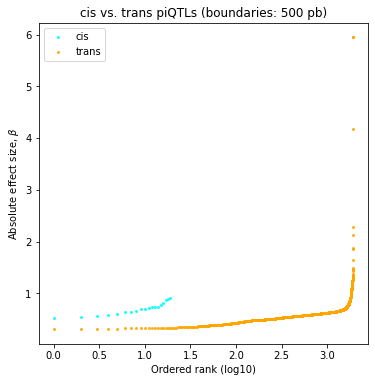

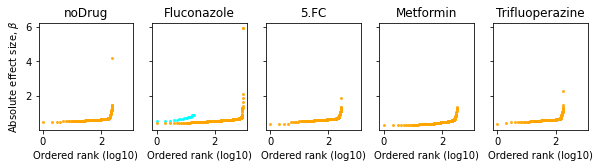

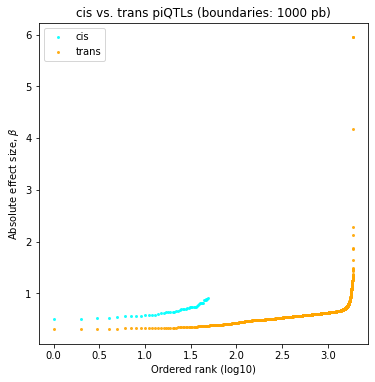

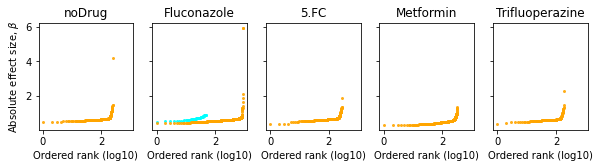

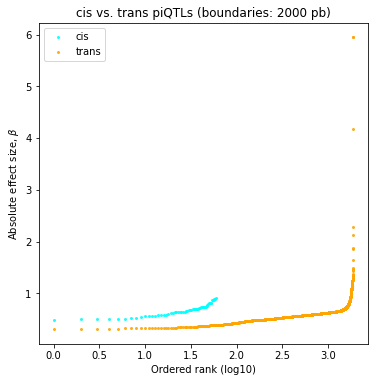

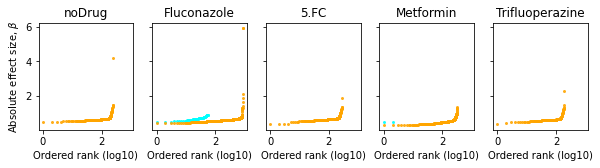

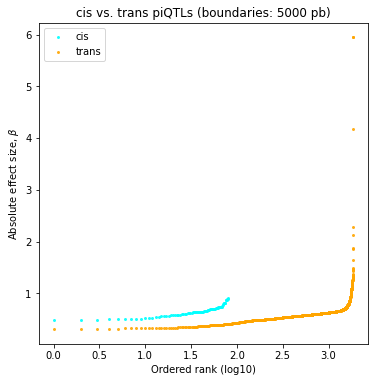

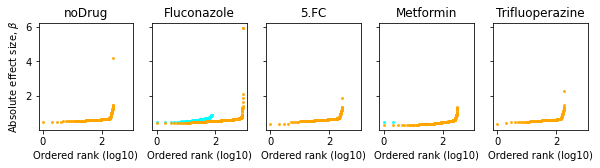

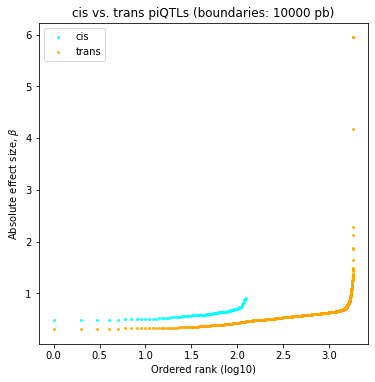

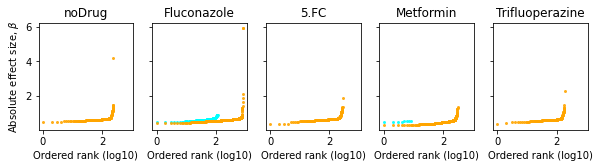

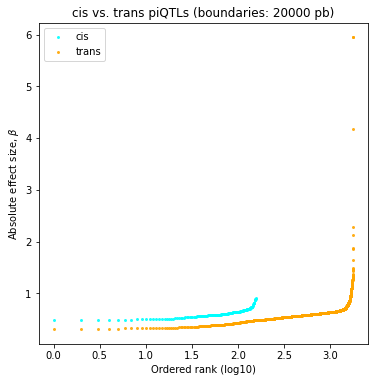

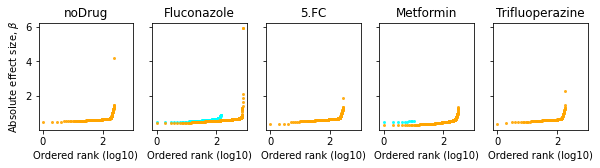

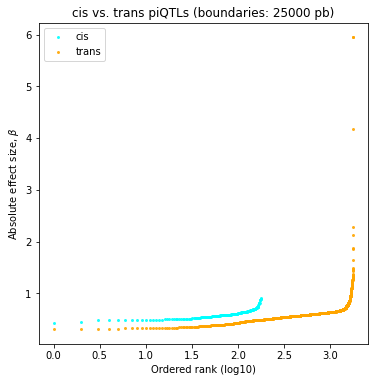

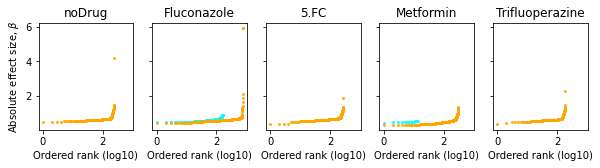

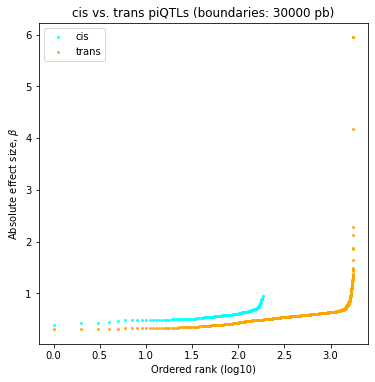

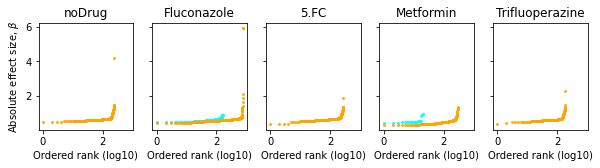

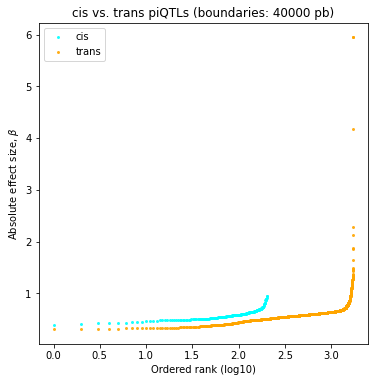

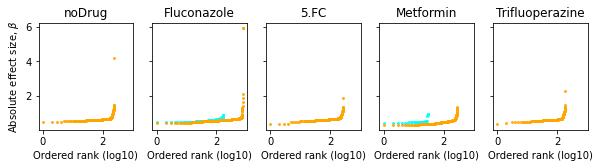

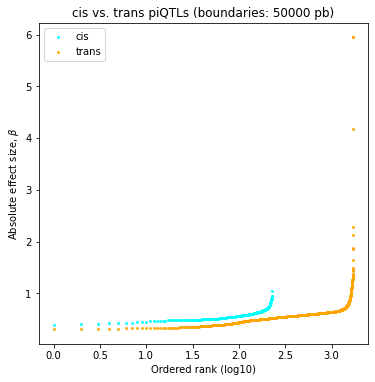

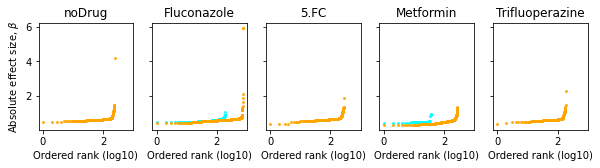

In [88]:
for limit in [500, 1000, 2000, 5000, 10000, 20000, 25000, 30000, 40000, 50000]:
    
    CM = 1/2.54 # centimeters in inches
    ALL_piQTLs['abs_Effect'] = np.abs(ALL_piQTLs['EFFECTSIZE'])
    f = plt.figure(figsize=(15*CM, 15*CM))
    for TYPE in np.unique(ALL_piQTLs[f'cis/trans_{limit}']):
        if 'cis' in TYPE :
            color = 'cyan'
        else : 
            color= 'orange'
        T = ALL_piQTLs[ALL_piQTLs[f'cis/trans_{limit}'] == TYPE].sort_values('abs_Effect', ascending=True).reset_index(drop=True)
        sns.scatterplot(y=T['abs_Effect'], x=np.log10(T.index), marker='.', linewidth=0, alpha = 0.9, color=color)
        plt.ylabel(r'Absolute effect size, $\beta$')
        plt.xlabel('Ordered rank (log10)')
        plt.legend(['cis','trans'])
        plt.title(f'cis vs. trans piQTLs (boundaries: {limit} pb)')

    f, axes = plt.subplots(figsize=(25 * CM, 5 * CM), nrows=1, ncols=5, sharey=True, sharex=True)
    i = 0
    for DRUG in ['noDrug', 'Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine' ]:
        T = ALL_piQTLs[ALL_piQTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)
        T['abs_Effect'] = np.abs(T['EFFECTSIZE'])
        for TYPE in np.unique(T[f'cis/trans_{limit}']):
            if 'cis' in TYPE :
                color = 'cyan'
            else : 
                color= 'orange'
            TMP = T[T[f'cis/trans_{limit}'] == TYPE].sort_values('abs_Effect', ascending=True).reset_index(drop=True)
            sns.scatterplot(y=TMP['abs_Effect'], x=np.log10(TMP.index), marker='.', linewidth=0, alpha = 0.9, color=color, ax=axes[i])
            # axes[i].set_xscale('log')
            axes[i].set_ylabel(r'Absolute effect size, $\beta$')
            axes[i].set_xlabel('Ordered rank (log10)')
            axes[i].set_title(DRUG)
        i += 1

/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getatt

ks-score:  14.793763045935185 p-value:  5.354587754774319e-47


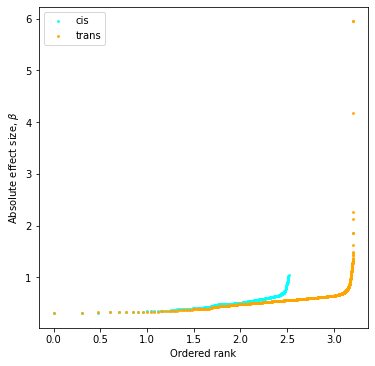

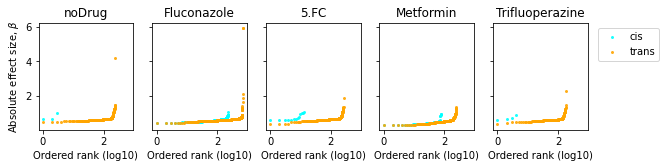

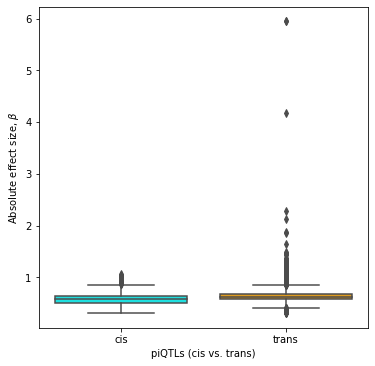

In [15]:
CM = 1/2.54 # centimeters in inches
ALL_piQTLs['abs_Effect'] = np.abs(ALL_piQTLs['EFFECTSIZE'])
f = plt.figure(figsize=(15*CM, 15*CM))
for TYPE in np.unique(ALL_piQTLs['cis/trans']):
    if 'cis' in TYPE :
        color = 'cyan'
    else : 
        color= 'orange'
    T = ALL_piQTLs[ALL_piQTLs['cis/trans'] == TYPE].sort_values('abs_Effect', ascending=True).reset_index(drop=True)
    sns.scatterplot(y=T['abs_Effect'], x=np.log10(T.index), marker='.', linewidth=0, alpha = 0.9, color=color)
    plt.ylabel(r'Absolute effect size, $\beta$')
    plt.xlabel('Ordered rank')
    plt.legend(['cis','trans'])
#f.savefig('../../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_ranked_all_combined.eps', dpi=300)

f, axes = plt.subplots(figsize=(25 * CM, 5 * CM), nrows=1, ncols=5, sharey=True, sharex=True)
i = 0
for DRUG in ['noDrug', 'Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine' ]:
    T = ALL_piQTLs[ALL_piQTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)
    T['abs_Effect'] = np.abs(T['EFFECTSIZE'])
    for TYPE in np.unique(T['cis/trans']):
        if 'cis' in TYPE :
            color = 'cyan'
        else : 
            color= 'orange'
        TMP = T[T['cis/trans'] == TYPE].sort_values('abs_Effect', ascending=True).reset_index(drop=True)
        sns.scatterplot(y=TMP['abs_Effect'], x=np.log10(TMP.index), marker='.', linewidth=0, alpha = 0.9, color=color, ax=axes[i])
        # axes[i].set_xscale('log')
        axes[i].set_ylabel(r'Absolute effect size, $\beta$')
        axes[i].set_xlabel('Ordered rank (log10)')
        axes[i].set_title(DRUG)
    i += 1

plt.legend(['cis','trans'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
## f.savefig('../../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_ranked_per_drug_xlog.eps', dpi=300)

CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(15*CM, 15*CM))
sns.boxplot(y=np.abs(ALL_piQTLs['EFFECTSIZE']), x=ALL_piQTLs['cis/trans'], palette=['cyan', 'orange'])
plt.ylabel(r'Absolute effect size, $\beta$')
plt.xlabel('piQTLs (cis vs. trans)')
ks_stat, pval = stats.ttest_ind(ALL_piQTLs[ALL_piQTLs['cis/trans'] == 'cis']['EFFECTSIZE'], ALL_piQTLs[ALL_piQTLs['cis/trans'] == 'trans']['EFFECTSIZE']) 
print('ks-score: ', ks_stat, 'p-value: ', pval)
# f.savefig('../../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_boxplot_all_combined_V2.eps', dpi=300)

CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(25*CM, 25*CM))
sns.violinplot(x=np.abs(ALL_piQTLs['EFFECTSIZE']), y=ALL_piQTLs['DRUG'], hue=ALL_piQTLs['cis/trans'], palette=['cyan', 'orange'])
plt.xlabel(r'Absolute effect size, $\beta$')
plt.ylabel('Drug')
f.savefig('../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_violinplot.eps', dpi=300)

for DRUG in ['Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine']:
    ks, pval = stats.kstest(ALL_piQTLs[(ALL_piQTLs['cis/trans'] == 'cis') & (ALL_piQTLs['DRUG'] == DRUG)]['EFFECTSIZE'], ALL_piQTLs[(ALL_piQTLs['cis/trans'] == 'trans') & (ALL_piQTLs['DRUG'] == DRUG)]['EFFECTSIZE'])
    print(DRUG, 'ks-statistic: ', ks, 'p-value: ', pval)

# f.savefig('../../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_violinplot_all_combined_V2.eps', dpi=300)